In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import os
import shutil

import warnings
warnings.filterwarnings("ignore")

In [23]:
# The images are in a folder named 'input/natural-images/natural_images'
training_folder_name = 'Skin Disease Classification/Train'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Skin Disease Classification/Train'

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

In [ ]:
from PIL import Image

# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.LANCZOS)

    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [ ]:
training_folder_name = 'Skin Disease Classification/Train'

# New location for the resized images
train_folder = 'data/train'


# Create resized copies of all of the source images
size = (128,128)

# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

print('Done.')

In [ ]:
def load_dataset(data_path):
    import torch
    import torchvision
    import torchvision.transforms as transforms
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader



# Recall that we have resized the images and saved them into
train_folder = 'data/train'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

# Meta Learning & Zero Short Neural Network

In [ ]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

### Training function

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

### Test function:

In [32]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

## Training the Model

In [35]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []


epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

NameError: name 'optim' is not defined

## View Loss History

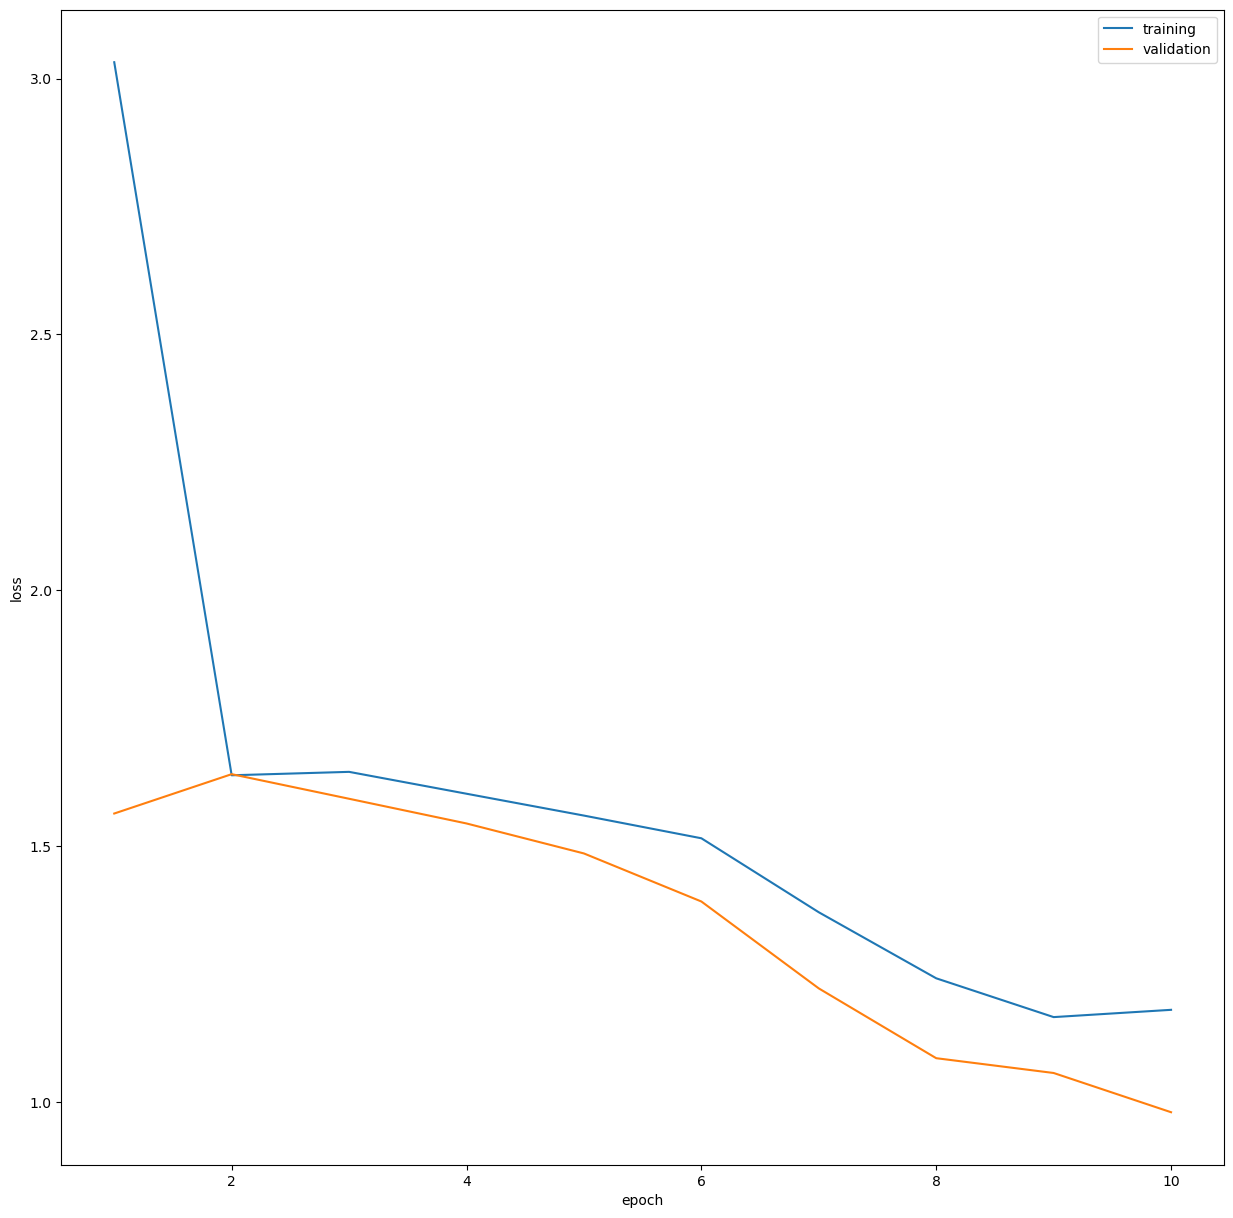

In [180]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Evaluate the Model

Getting predictions from test set...


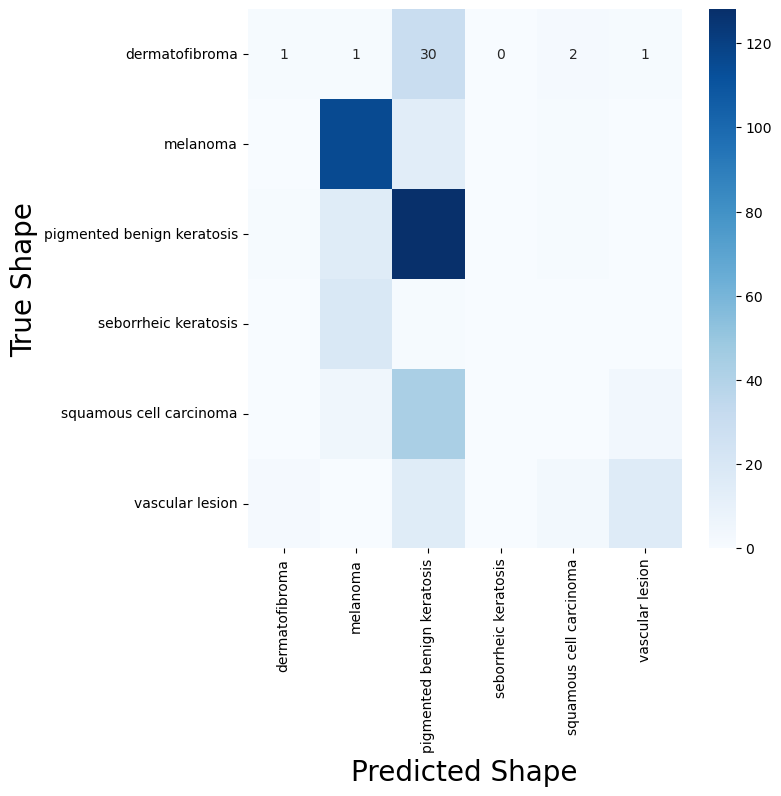

In [182]:
# Defining Labels and Predictions
truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

For Fine Tuning TL & GAN

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [9]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [11]:
import glob
import os
import PIL
import time

from IPython import display

In [12]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path1 = 'Skin Disease Classification/Train'
test_path1 = 'Skin Disease Classification/Test'

In [18]:
# Scaling all the images between 0 to 1

train_datagen1 = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen1 = ImageDataGenerator(rescale=1./255)

In [20]:
train_set1 = train_datagen1.flow_from_directory(train_path1,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode = 'categorical')

test_set1 = test_datagen1.flow_from_directory(test_path1,
                                            target_size=(224,224),
                                            batch_size=8,
                                            class_mode='categorical')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Skin Disease Classification/Train'

In [192]:
## GAN

In [4]:
def define_discriminator(in_shape=(224,224,3)):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(negative_slope=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(negative_slope=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(negative_slope=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer
	d_out_layer = Dense(6, activation='sigmoid')(fe)
	# define and compile discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5))
	return d_model

In [6]:
model = define_discriminator()

NameError: name 'Input' is not defined

In [195]:
model.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2856 (Conv2D)            │ (None, 112, 112, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2857 (Conv2D)            │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2858 (Conv2D)            │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 6)              │       602,118 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,870 (3.44 MB)

 Trainable params: 900,870 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
r1 = model.fit(train_set1, validation_data=test_set1, epochs=10)

NameError: name 'model' is not defined

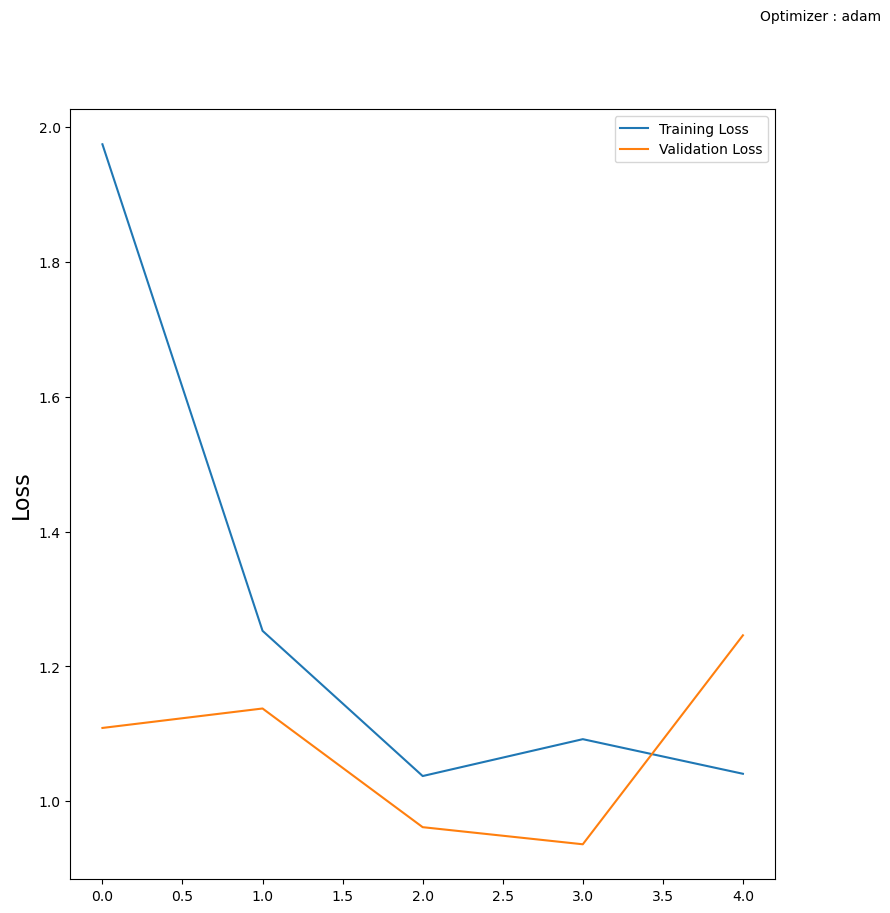

In [294]:
import matplotlib.pyplot as plt

x= r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')


# TL

In [205]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


InceptionResNetV2# InceptionResNetV2

In [290]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_set1.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [270]:

history = model.fit(train_set1, validation_data=test_set1, epochs=5, steps_per_epoch=train_set1.samples  // batch_size, validation_steps=test_set1.samples  // batch_size)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6098 - loss: 0.9877 - val_accuracy: 0.5972 - val_loss: 1.0584
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6527 - loss: 0.9071 - val_accuracy: 0.7037 - val_loss: 0.8824
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7141 - loss: 0.7682 - val_accuracy: 0.7222 - val_loss: 0.7435
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 879ms/step - accuracy: 0.6619 - loss: 0.8998 - val_accuracy: 0.6898 - val_loss: 0.8088
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6619 - loss: 0.8206 - val_accuracy: 0.7176 - val_loss: 0.7792


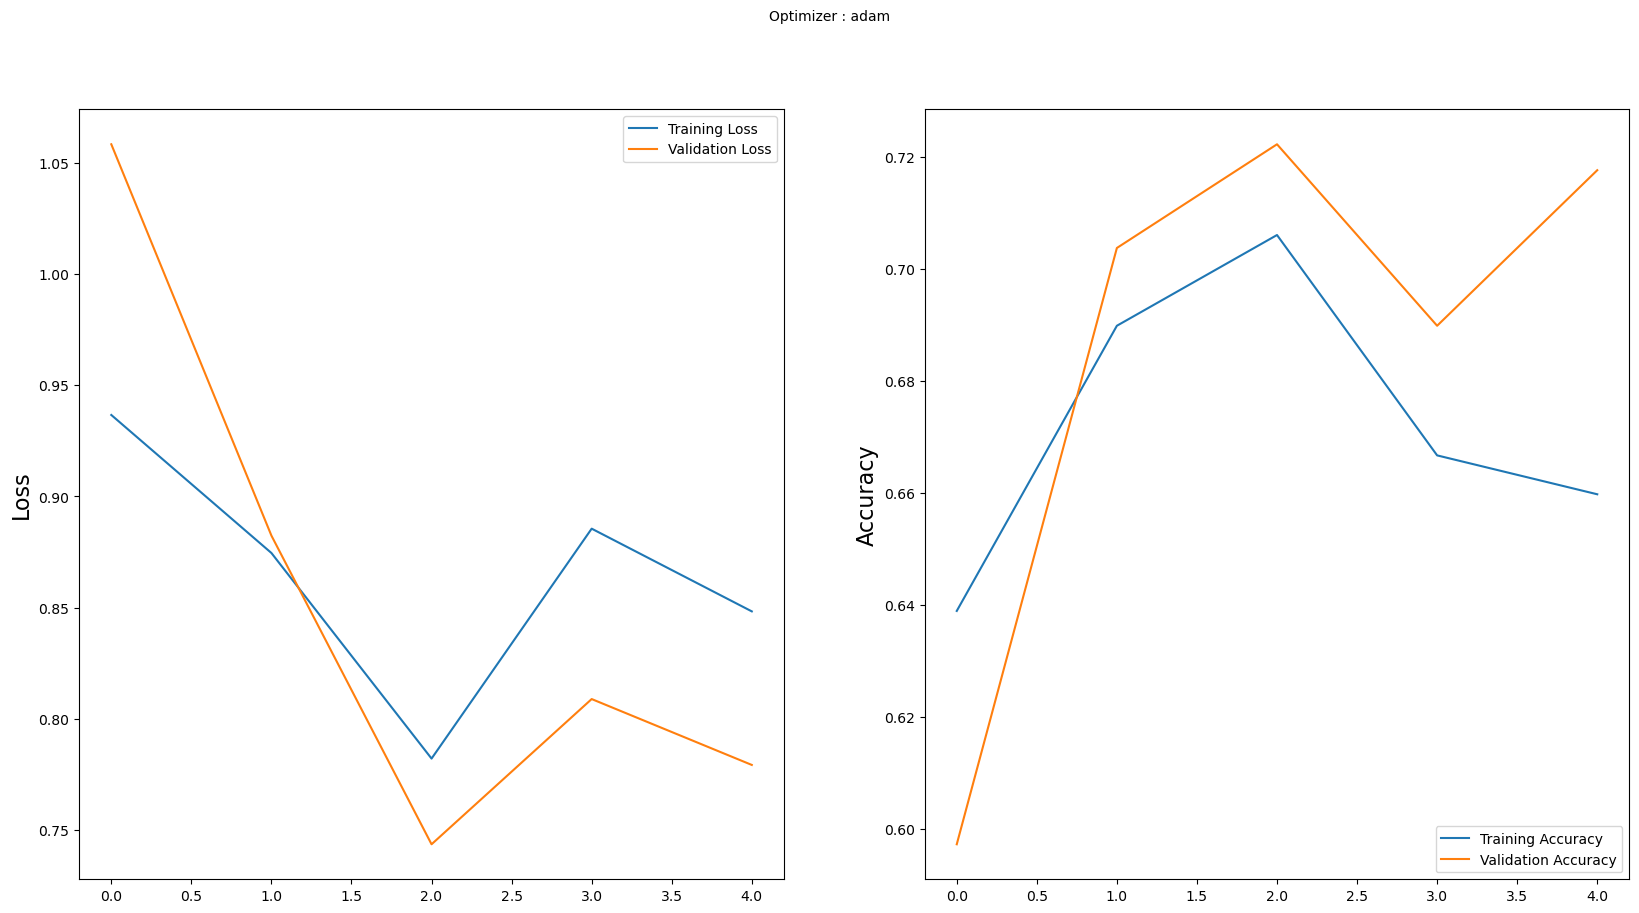

In [273]:
x = history
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNet

In [239]:
from tensorflow.keras.applications import MobileNet, MobileNetV2
mob = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [288]:
x1= Flatten()(mob.output)
prediction1 = Dense(6, activation='softmax')(x1)
model12 = Model(inputs = mob.inputs, outputs = prediction1)



# Compile the model
model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [262]:
# Train MobileNet model
r1 = model12.fit(train_set1, validation_data=test_set1, epochs=5, steps_per_epoch=train_set1.samples  // batch_size, validation_steps=test_set1.samples  // batch_size)



Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 994ms/step - accuracy: 0.8249 - loss: 0.6704 - val_accuracy: 0.8148 - val_loss: 0.8573
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 954ms/step - accuracy: 0.8150 - loss: 0.5227 - val_accuracy: 0.7870 - val_loss: 1.2786
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 981ms/step - accuracy: 0.8233 - loss: 0.8144 - val_accuracy: 0.7546 - val_loss: 1.3186
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.7822 - loss: 0.6117 - val_accuracy: 0.7685 - val_loss: 1.2326
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 933ms/step - accuracy: 0.8418 - loss: 0.4341 - val_accuracy: 0.8380 - val_loss: 0.8888


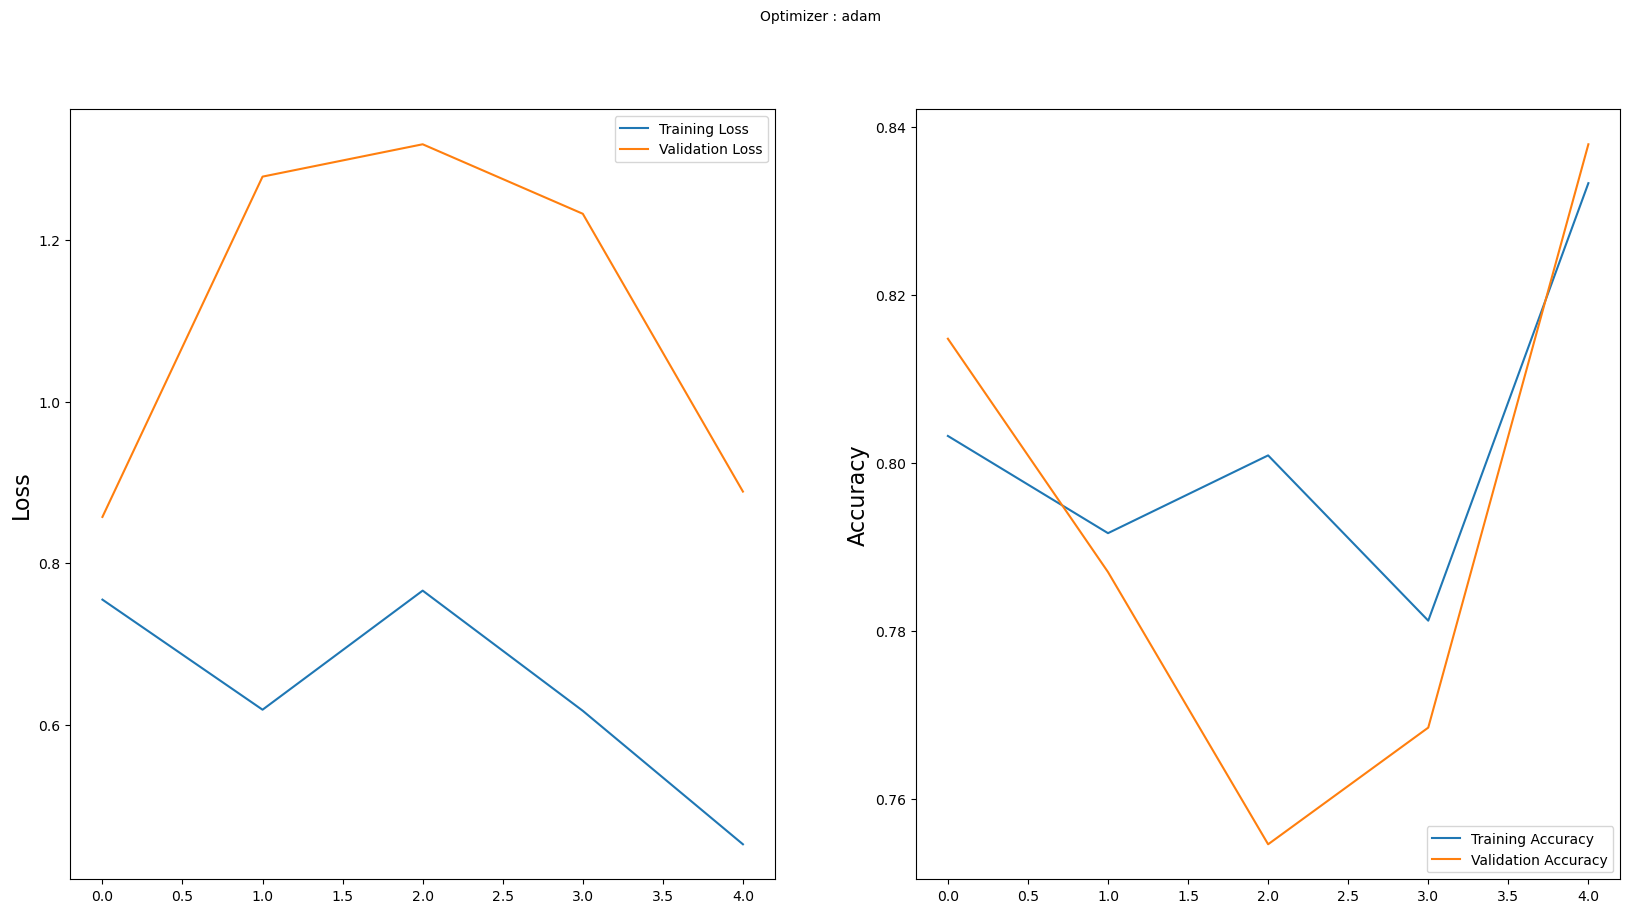

In [268]:
 import matplotlib.pyplot as plt
x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [225]:
#model12.save('model1.h5')

# CNN Model 

In [227]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [228]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_set1.num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [282]:
# Train CNN model
cnn_history = cnn_model.fit(train_set1, validation_data=test_set1, epochs=5, steps_per_epoch=train_set1.samples  // batch_size, validation_steps=test_set1.samples  // batch_size)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 467ms/step - accuracy: 0.6943 - loss: 0.8641 - val_accuracy: 0.5370 - val_loss: 1.2154
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.5761 - loss: 1.0556 - val_accuracy: 0.6759 - val_loss: 0.8721
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.6856 - loss: 0.8575 - val_accuracy: 0.6991 - val_loss: 0.8607
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6691 - loss: 0.9595 - val_accuracy: 0.7176 - val_loss: 0.7894
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 571ms/step - accuracy: 0.7142 - loss: 0.8464 - val_accuracy: 0.6389 - val_loss: 0.9212


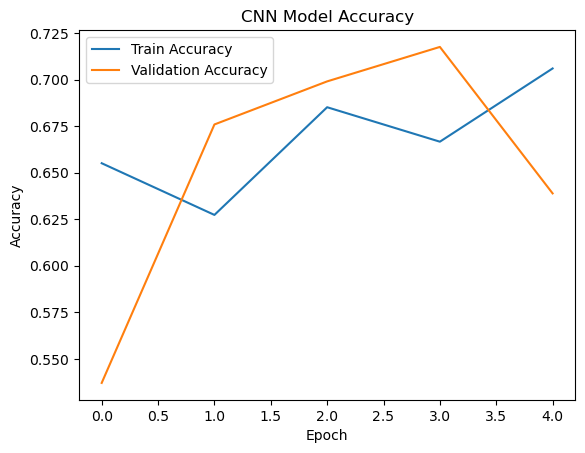

In [283]:
# Plot CNN model accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
